# Data simulation
Here, the concepts from the `02_Data_simulation_explanation` script are implemented for the entire data set.

### Preliminaries
The packages and functions from the `02_Data_simulation_explanation` script are used again.

In [ ]:
%%capture
!pip install pymc3

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy.stats import norm
from itertools import permutations
from itertools import chain

sns.set_context('talk')

In [ ]:
import random as random

In [ ]:
def cumulative_normal(x, alpha, beta):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * math.erf((x - alpha) / (beta * np.sqrt(2)))

Set a seed for the random number generator to help with reproducibility:

In [ ]:
random.seed(42)

Create a function that outputs plots as well as the statistics.
Right now the plotting functionality has not been implemented yet, but you can easily add it at the indicated spot below.


In [ ]:
def bayes_fit(name, x, n, r, stats = True, plot = True):
  results = [name]
  
  with pm.Model():

    alpha = pm.Uniform("alpha", lower = -40.5, upper = 40.5)
    beta = pm.HalfNormal("beta", 100)

    theta = pm.Deterministic(
        "theta", cumulative_normal(x, alpha, beta)
    )

    r_ = pm.Binomial("rij", p=theta, n=n, observed=r)
    trace = pm.sample(
        chains=4, cores=4, tune=4000, draws=2000, return_inferencedata=True, target_accept=0.95
    )
  az.plot_trace(trace, var_names=['alpha', 'beta'])
  plt.show()
  if stats == True:
    stats = az.summary(trace, ["alpha", "beta"])
    results.append(stats)
  if plot == True:
    # add plotting code here
    results.append("plot")

  return(results)

In [ ]:
psychophysics_df = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

### All subjects
We now apply the principles from the `02_Data_simulation_explanation` script to all data. We take the following steps:

*   Randomize the doses over the sessions (for each subject separately)
*   Choose 1 subject
*   Select their interoceptive or exteroceptive condition
*   Calculate the current bias and precision (i.e., width of the uncertainty interval)
*   Adapt the bias and the width of the uncertainty interval according to the hypotheses
*   Simulate new data using the new bias and width of the uncertainty interval
*   Save the new data
*   Calculate the new bias and precision and make plots

A function to simulate all the data:

In [ ]:
def originaldata(subject, modality):
  # select the subject and intero / exteroception condition
  this_df = psychophysics_df[(psychophysics_df.Modality == modality) & (psychophysics_df.Subject == subject)]
  this_df = this_df[['Alpha', 'Decision']] # retrieve the relevant information

  # retrieve the original x, n, and r vectors
  x, n, r = np.zeros(163), np.zeros(163), np.zeros(163)

  for ii, intensity in enumerate(np.arange(-40.5, 41, 0.5)):
      x[ii] = intensity
      n[ii] = sum(this_df.Alpha == intensity)
      r[ii] = sum((this_df.Alpha == intensity) & (this_df.Decision == "More"))

  # remove no responses trials
  validmask = n != 0
  xij, nij, rij = x[validmask], n[validmask], r[validmask]

  return([xij, nij, rij])

In [ ]:
def simulation(subject, modality, changebias, changeprecision, dose, session, sessionbias, sessionprecision):
  
  d = originaldata(subject, modality)
  xij = d[0]
  nij = d[1]
  rij = d[2]

  # if the dose is 0, there is no change
  # we want to retrieve the original data
  if dose == 0:
    exp = {'subjectID': [subject] * len(xij),
         'modality': [modality] * len(xij),
         'dose': [dose] * len(xij),
         'session': [session] * len(xij),
         'x': xij,
         'n': nij,
         'r': rij} 
  
  # if the dose is not 0, there is change
  else:
    # determine the (width of the) uncertainty interval and bias
    interval_min = min(xij[np.where((rij / nij != 0) & (rij / nij != 1))])
    interval_max = max(xij[np.where((rij / nij != 0) & (rij / nij != 1))])

    width = abs(interval_min) + abs(interval_max)
    bias = (interval_min + interval_max) / 2

    # determine the new width and bias
    widthnew = width * (1 + (changeprecision + sessionprecision))
    biasnew = bias * (1 + (changebias + sessionbias)) # note that to make the bias decrease you have to enter (for example) -0.05
    uncertaintynew_min = biasnew - (widthnew / 2)
    uncertaintynew_max = biasnew + (widthnew / 2)

    # create the new data
    newdatx = [-30, -20, -10, 10, 20, 30]
    newdatn = [2] * 6

    newx = [0] * 48
    numx = random.choice(range(17,34)) # number of unique intensities
    newx = np.random.normal(biasnew, (0.8 * uncertaintynew_max) / 0.5, numx)
    newx = np.around(np.ndarray.tolist(newx)) * 0.5

    for i in range(0, len(newx)):
      if (newx[i] - int(newx[i])) == 0:
        newx[i] = newx[i] + random.choice([-0.5, 0.5])

    newn = [1] * len(newx)
    while sum(newn) < 48:
      ind = random.choice(range(0, len(newx)))
      newn[ind] = newn[ind] + 1

    newdatx = newdatx + newx.tolist()
    newdatn = newdatn + newn

    newdatr = [0] * len(newdatx)

    for i in range(0, len(newdatx)):
      if newdatx[i] < uncertaintynew_min:
        newdatr[i] = 0
      elif newdatx[i] > uncertaintynew_max:
        newdatr[i] = newdatn[i]
      else:
        newdatr[i] =  round(norm.cdf(newdatx[i], biasnew, 0.95 * (widthnew / 2)) * newdatn[i])

    # collect all information into 1 dataframe and return it
    exp = {'subjectID': [subject] * len(newdatx),
          'modality': [modality] * len(newdatx),
          'dose': [dose] * len(newdatx),
          'session': [session] * len(newdatx),
          'x': newdatx,
          'n': newdatn,
          'r': newdatr}
  
  # return the created data frame
  return(pd.DataFrame(data = exp))

We now randomize the doses over each session for each participant. Note that when using hierarchical Bayes you can do this completely randomly. For the 3-way repeated measures ANOVA, however, the groups need to be balanced (i.e., the same amount of participants needs to receive dose 5 in session 1 as dose 5 in session 2). This randomization can also be used for the hierarchical Bayes model. The use of this randomization is limited because the balanced groups imply the sample size needs to be a multiple of 24. You may still implement a Latin square type of design to use instead.
This code gives both the fully randomized option and the option that can be used with 3-way repeated measures ANOVA. Simply change `RMANOVA` to False or True accordingly.  
This code gives the option to generate data for only a given number of participants. If you want to generate simulated data for all subjects in the data from Legrand et al., choose N  = 191.

In [ ]:
# choose your sample size (multiple of 24 when using 3-way RM ANOVA)
N = 48
# choose whether you want the sample to be used for 3-way RM ANOVA or not
RMANOVA = True

In [ ]:
# retrieve N randomly sampled subjects from the original data set
subjects = random.sample(psychophysics_df["Subject"].unique().tolist(), N) # array with every unique subject ID
# set up the sessions for each participant
session_sample = [1, 2, 3, 4] * N
subjectID_sample = np.repeat(subjects, 4)
order = []

if RMANOVA == True:
  perm = list(permutations([0,5,10,15]))
  reps = N / len(perm)
  if not reps.is_integer(): # check that the sample size is a multiple of 24 (the number of permutations)
  # if you change to a Latin square design, you could check here if the sample size is a multiple of 4
    raise Exception("Ensure N is multiple of 24 OR set RMANOVA = False")
  doserand = list(chain(*perm)) * int(reps)
  for i in range(0, N * 4):
    order = order + [doserand[i]]
else:
  for i in range(0, N):
    order = order + random.sample([0, 5, 10, 15], 4)

# add everything together
samples = {'subjectID': subjectID_sample,
           'session': session_sample,
           'dose': order}
samples = pd.DataFrame(samples)

# show the data frame
samples.head()

subjectID  session  dose
0  sub_0225        1     0
1  sub_0225        2     5
2  sub_0225        3    10
3  sub_0225        4    15
4  sub_0061        1     0

Now simulate the data for all subjects and treatment combinations.

If you want to change the effect of the drugs for the interoceptive condition you can change `changeeffectalpha` to change the bias(note that to make the bias decrease you have to choose negative values) and `changeeffectbeta` to change the precision.
To do the same for the exteroceptive condition, you can change `changeeffectalphaex` and `changeeffectbetaex`, respectively.

If you want to change the learning effect over the sessions, you can change `changesessionalpha` to change the bias and `changesessionbeta` to change the precision (note that you have to choose negative values to increase the precision).

NOTE: running the code below can take multiple hours. The data generated by this code is available in the folder with all scripts. If you don't want to change anything we recommend using the .csv files from the folder.

In [ ]:
# changes due to the drug
changeeffectalpha = [0, -0.1, -0.3, -0.5] # bias decreases
changeeffectbeta = [0, 0.1, 0.3, 0.5] # precision decreases (width of uncertainty increases)
changeeffectalhpaex = [0, 0, 0, 0] # in the exteroceptive condition, we do not expect a change in bias due to the drug
changeeffectbetaex = [0, 0.1, 0.3, 0.5]
# changes due to the session effect
changesessionalpha = [0, -0.05, -0.07, -0.1] # bias decreases
changesessionbeta = [0, -0.05, -0.07, -0.1] # precision increases (width of uncertainty decreases)

sub_0225
Intero


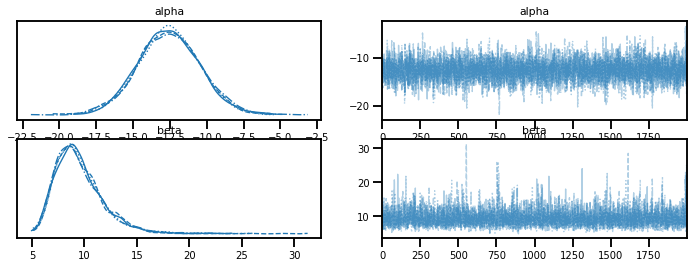

ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


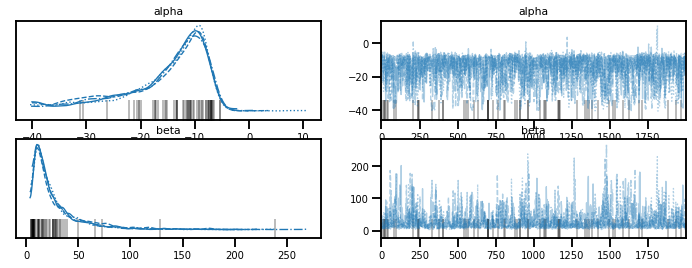

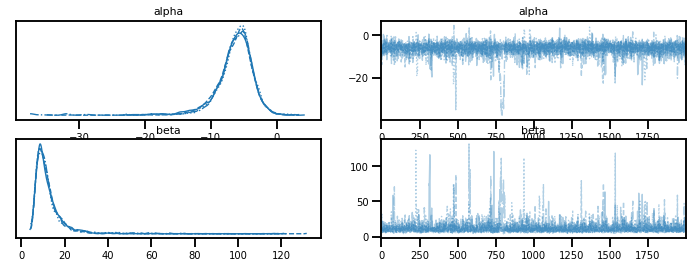

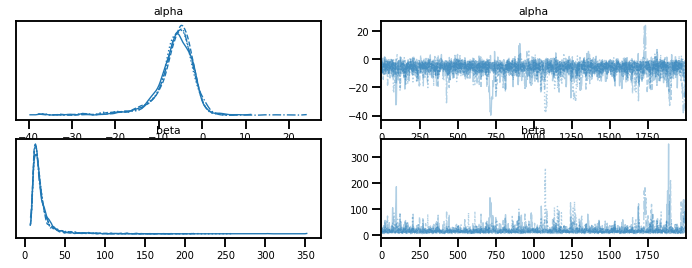

Extero


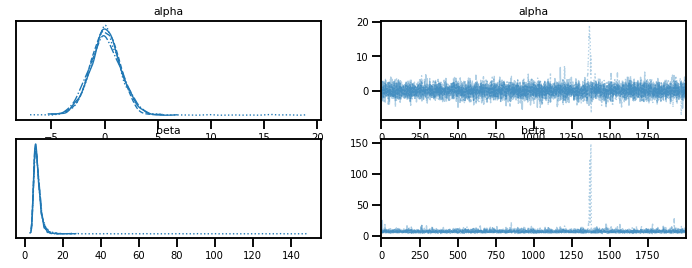

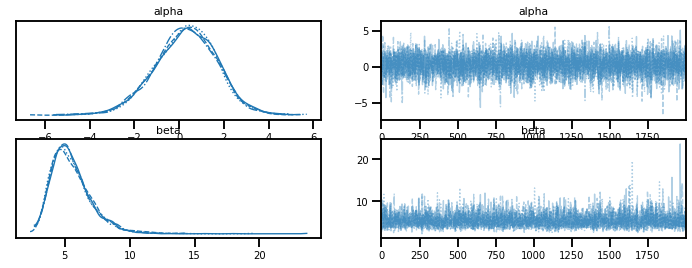

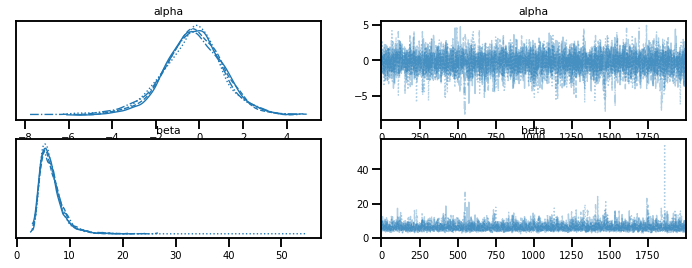

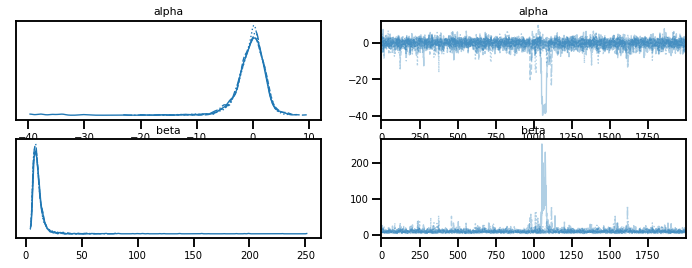

sub_0061
Intero


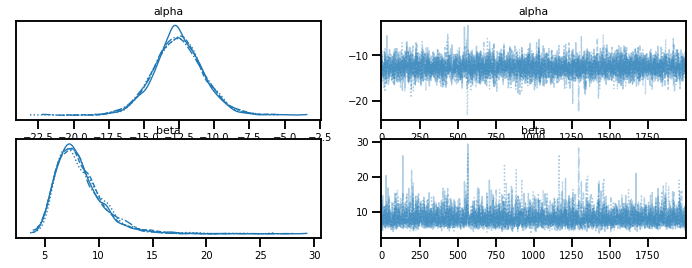

ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


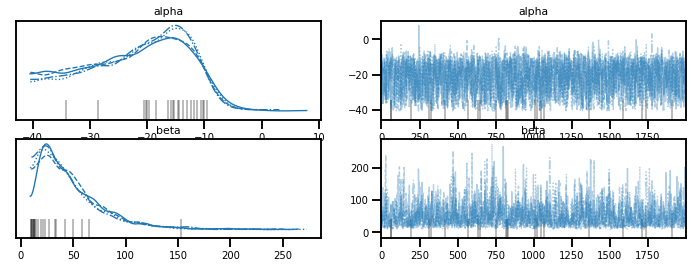

ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


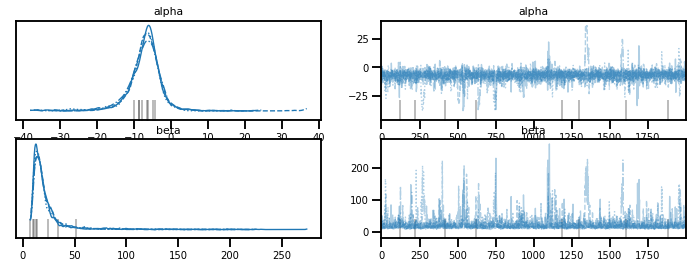

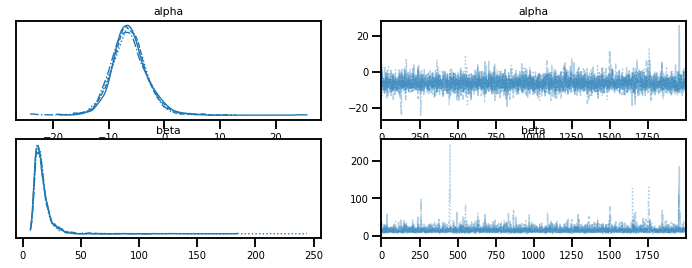

Extero


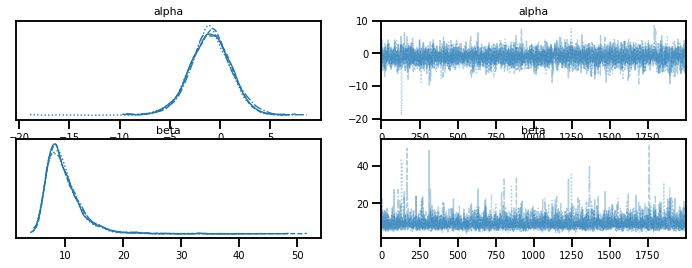

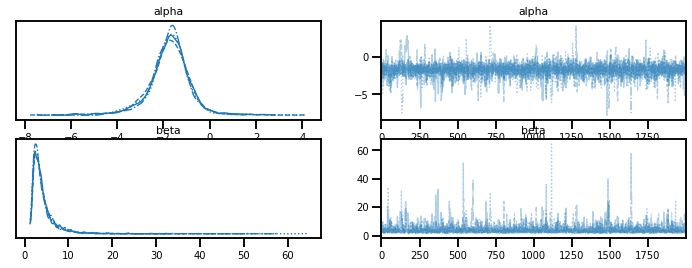

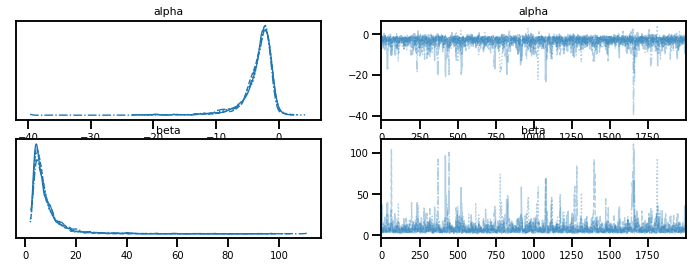

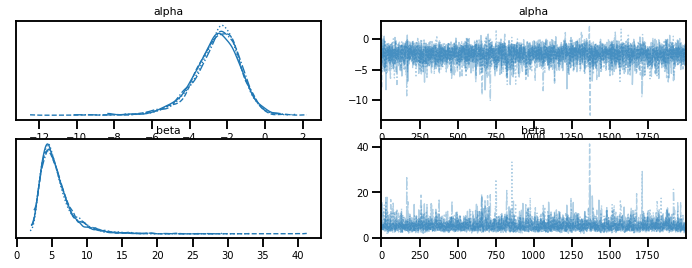

sub_0027
Intero


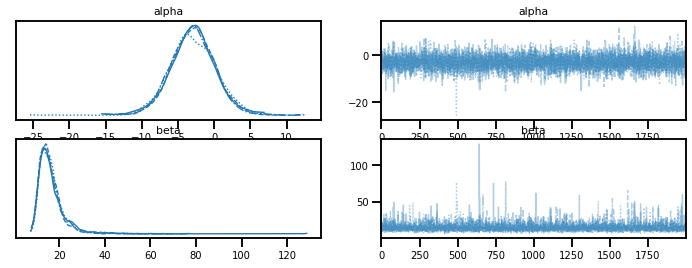

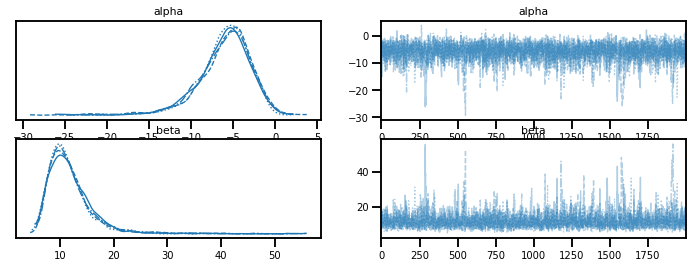

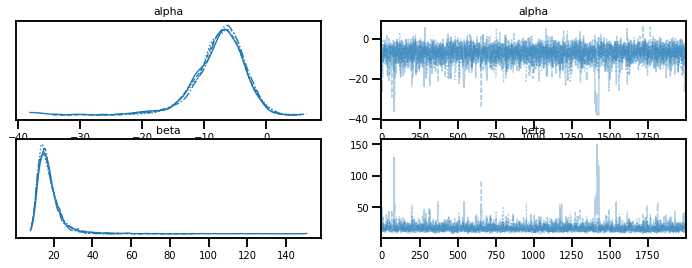

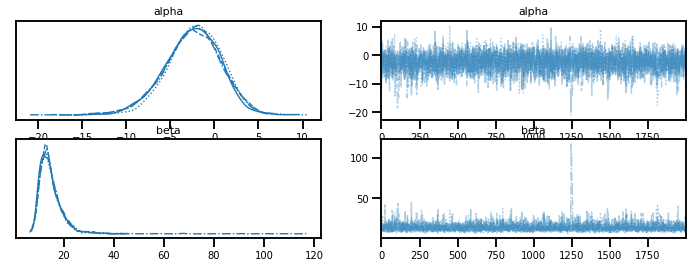

Extero


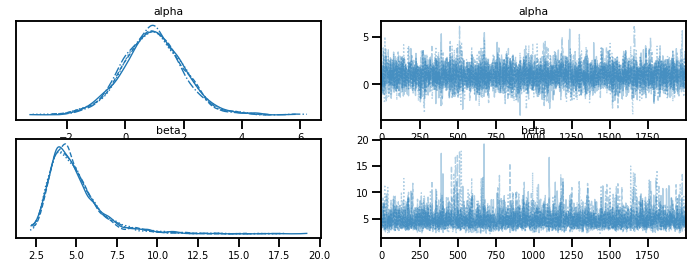

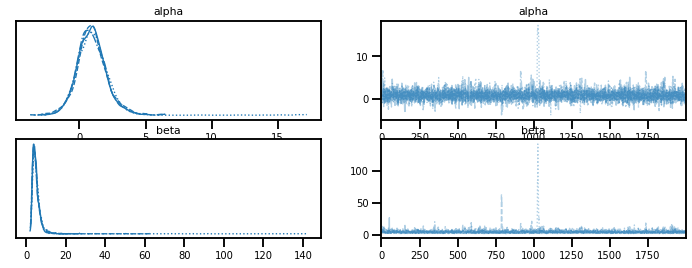

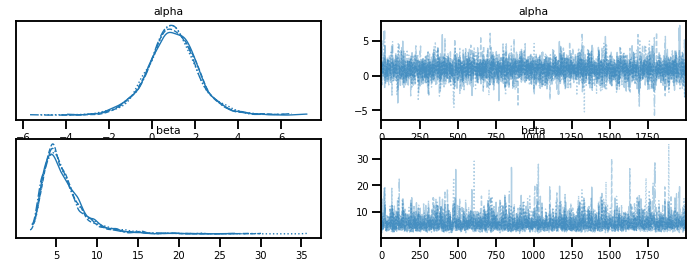

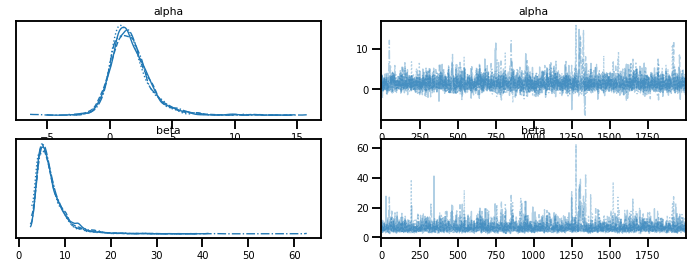

sub_0113
Intero


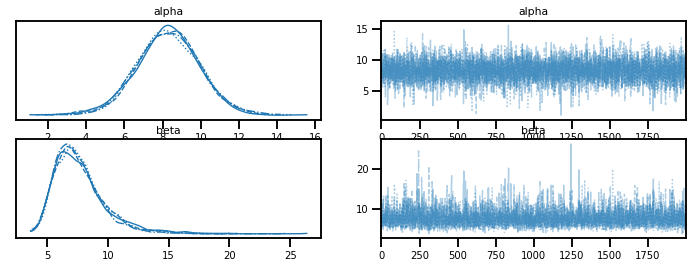

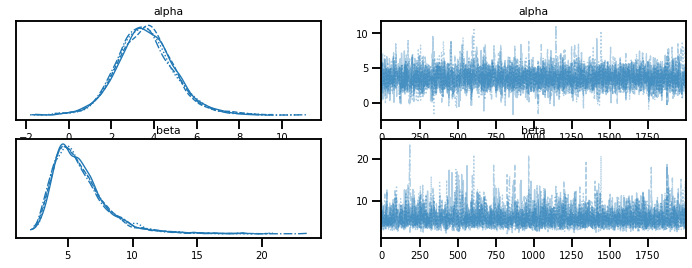

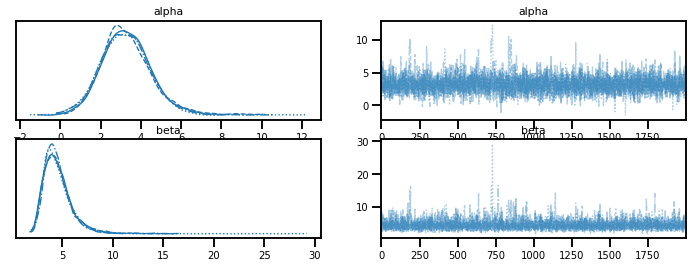

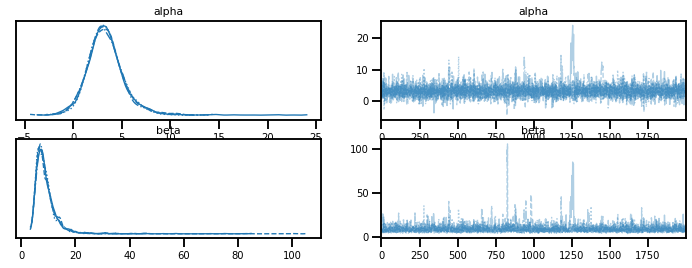

Extero


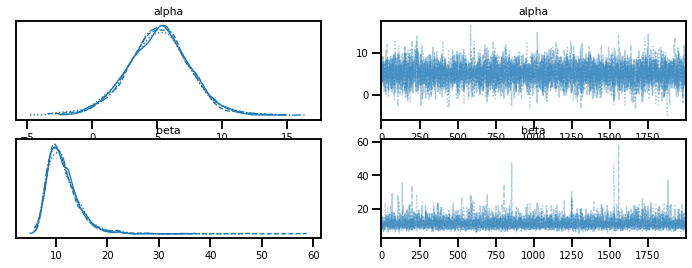

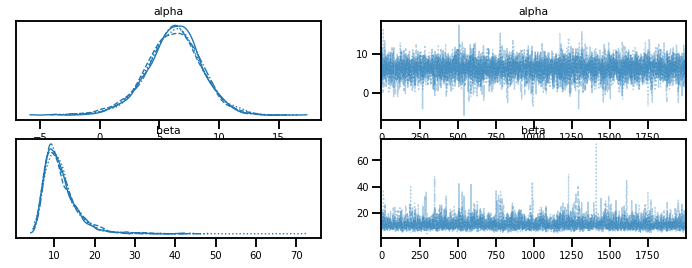

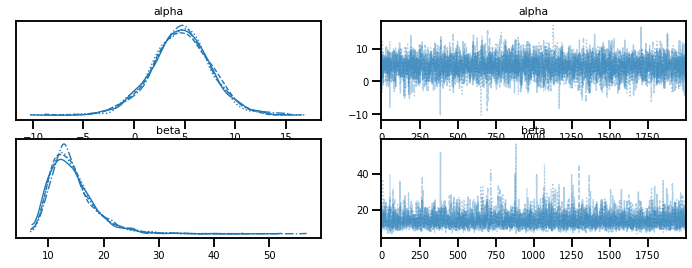

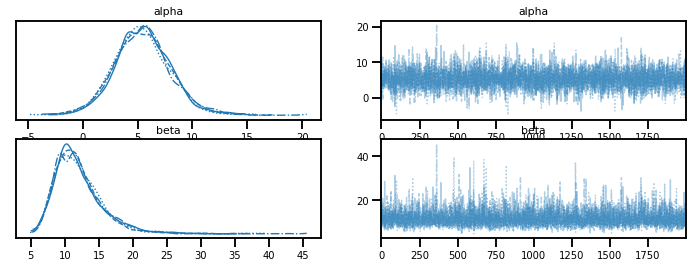

sub_0102
Intero


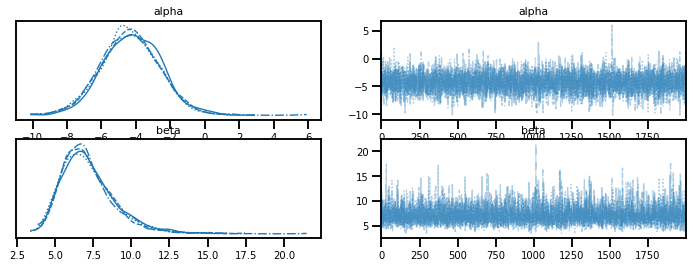

ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


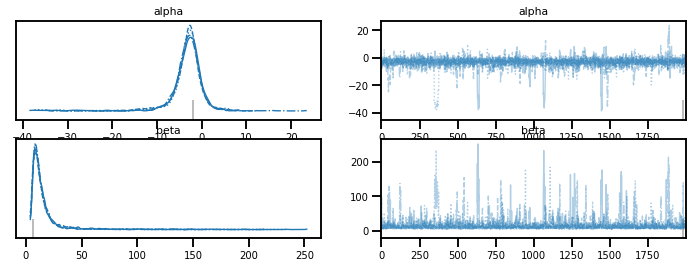

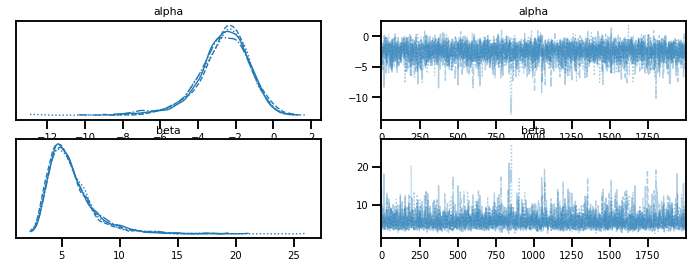

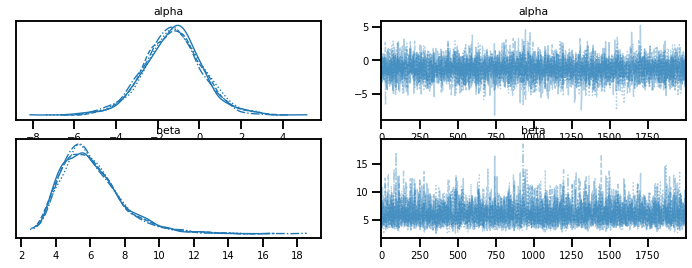

Extero


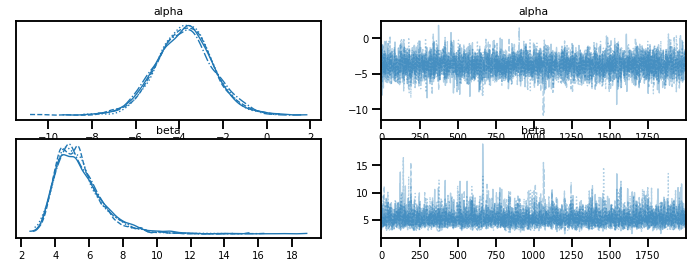

ERROR:pymc3:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


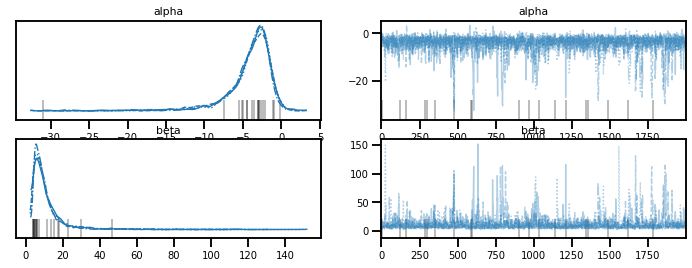

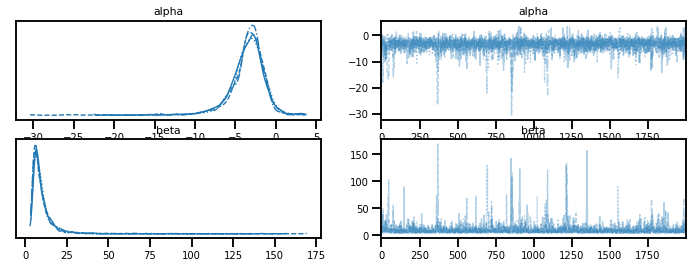

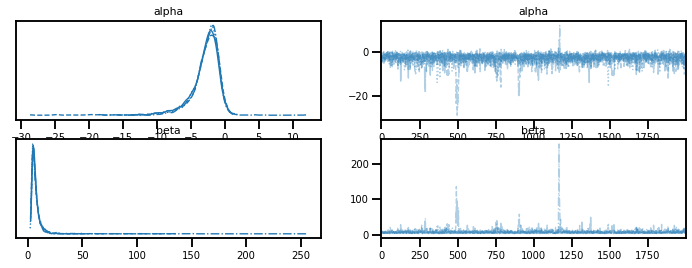

sub_0097
Intero


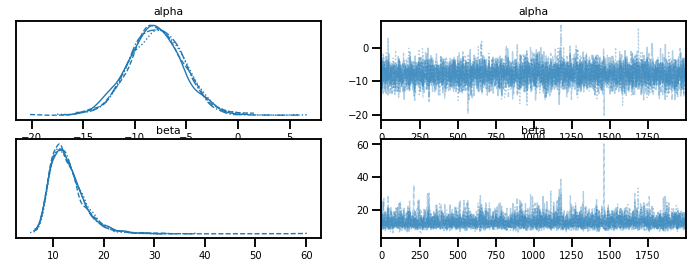

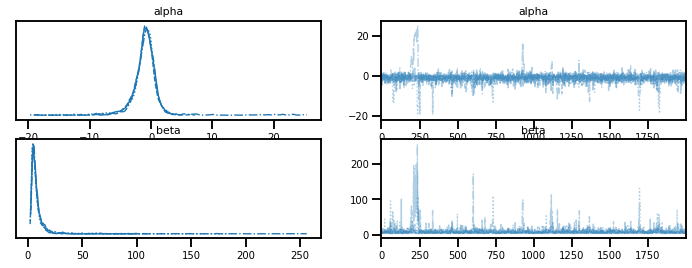

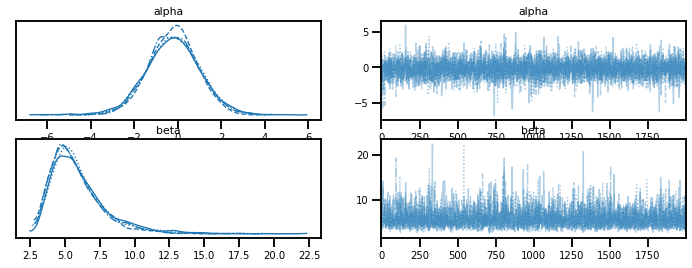

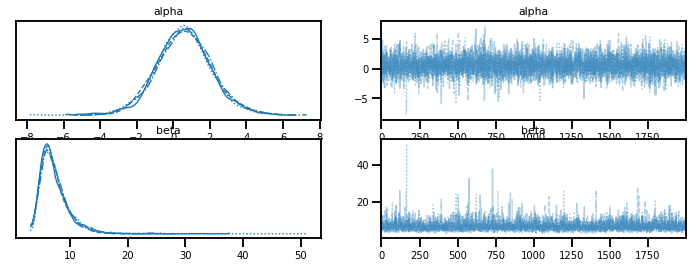

Extero


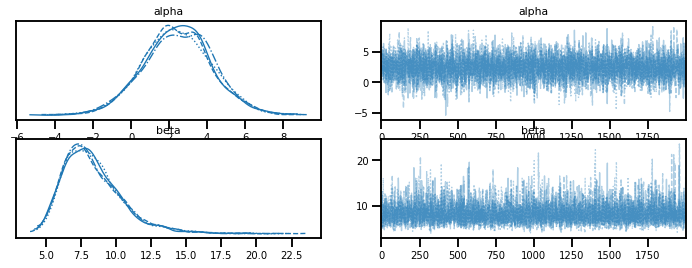

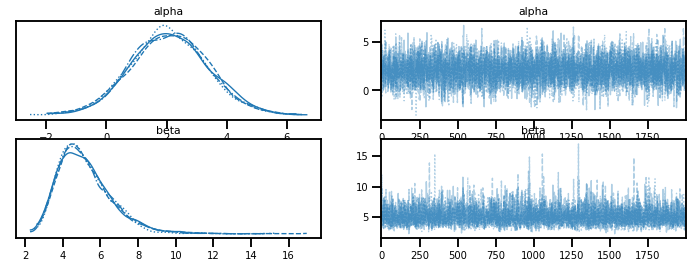

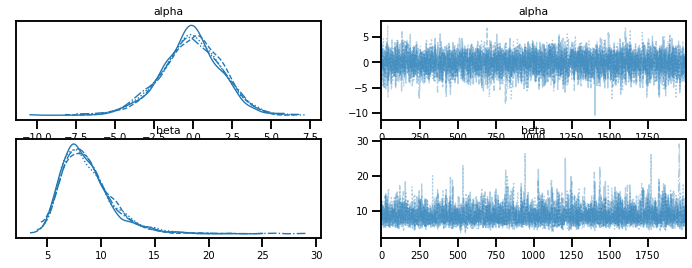

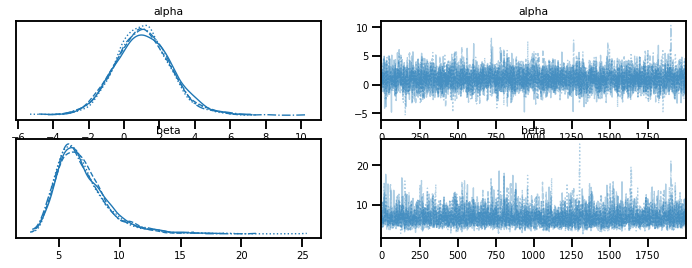

sub_0070
Intero


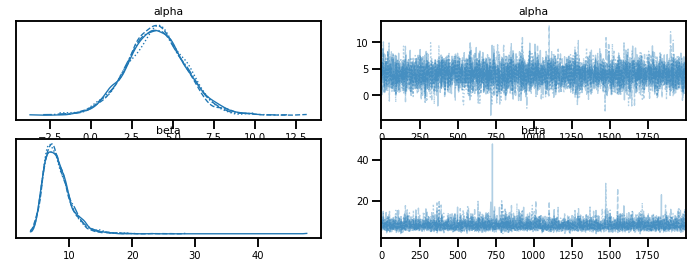

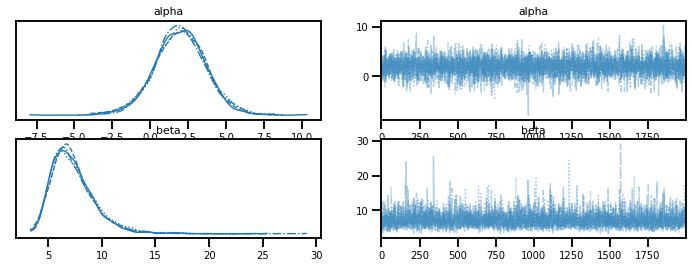

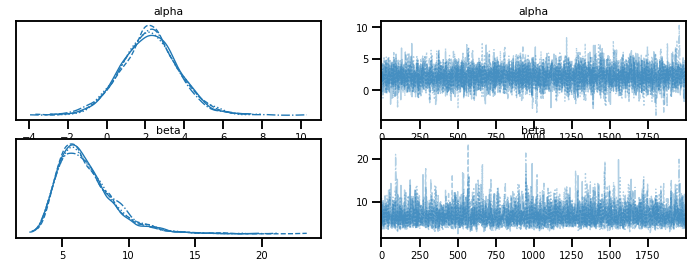

ValueError: ignored

In [ ]:
modalities = ["Intero", "Extero"]
doses = [0, 5, 10, 15]
session = [1, 2, 3, 4]

Ncases = 4 * 2 * len(subjects)

# create an empty dataframe to store the fitted data
simulated_data_subject = [''] * Ncases
simulated_data_modality = [''] * Ncases
simulated_data_dose = [0] * Ncases
simulated_data_session = [0] * Ncases
simulated_data_alpha = [0] * Ncases
simulated_data_beta = [0] * Ncases

# data frame to store raw simulated data (i.e., x, n, and r for each subject and condition)
simulated_data_raw = pd.DataFrame(columns = ['subjectID', 'modality', 'dose', 'session', 'x', 'n', 'r'])
q = 0 # counting variable

for i in subjects:
  print(i)
  for j in modalities:
    print(j)
    for k in range(0,len(changeeffectalpha)):
      if j == 'Intero':
        changebias = changeeffectalpha[k]
        changeprecision = changeeffectbeta[k]
      else:
        changebias = changeeffectalhpaex[k]
        changeprecision = changeeffectbetaex[k]
      sessionnumber = int(samples.where((samples['dose'] == doses[k]) & (samples['subjectID'] == i))['session'].dropna())
      d = simulation(subject = i, modality = j, changebias = changebias, changeprecision = changeprecision, dose = doses[k],
                     session = sessionnumber, sessionprecision = changesessionbeta[sessionnumber - 1], sessionbias = changesessionalpha[sessionnumber -1])
      simulated_data_raw = pd.concat([simulated_data_raw, d])
      fit = bayes_fit(name = ' ', x = d['x'].tolist(), n = d['n'], r = d['r'], stats = True, plot = True)
      simulated_data_alpha[q] = fit[1].iloc[0]["mean"]
      simulated_data_beta[q] = fit[1].iloc[1]["mean"]
      simulated_data_subject[q] = i
      simulated_data_modality[q] = j
      simulated_data_dose[q] = doses[k]
      simulated_data_session[q] = sessionnumber
      q = q + 1

simulated_data_fitted = {'subjectID': simulated_data_subject,
         'modality': simulated_data_modality,
         'dose': simulated_data_dose,
         'session': simulated_data_session,
         'bias': simulated_data_alpha,
         'precision': simulated_data_beta,}
simulated_data_fitted = pd.DataFrame(data = simulated_data_fitted)

The fitted simulated data can now be used for the repeated measures ANOVA analysis

In [ ]:
simulated_data_fitted.head()

The unfitted (raw) simulated data is available for using with the hierarchical Bayes method

In [ ]:
simulated_data_raw.tail()

Here we store the dataframes, you can find the saved versions in the folder with all the scripts (no need to run this code):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path_raw = '/content/drive/MyDrive/Colab Notebooks/Statistical Consulting Project/simulated_data_raw.csv'
simulated_data_raw.to_csv(path_raw)
path_fit = '/content/drive/MyDrive/Colab Notebooks/Statistical Consulting Project/simulated_data_fit.csv'
simulated_data_fitted.to_csv(path_fit)